### Imports

In [4]:
# Libraries, installations, and data import to Spark system
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=e35a2b755d8d4b7d8cb9bbcb2352fbb8dc8981d3fe9ae303660d7d06fb161caa
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [5]:
import numpy as np
import pandas as pd

from pyspark.sql.functions import col, expr, rand, udf
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import array, rand

import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score

from sklearn.preprocessing import MinMaxScaler

# Creating K-Means Algorithm

### Create Sub-Functions

###### Normalize the Data

In [6]:
def Normalize_dataset(dataset):
    scaler = MinMaxScaler()

    columns = dataset.columns
    features_cols = columns[:-1]
    class_col = columns[-1]

    # Convert Spark DataFrame to Pandas DataFrame
    dataset = dataset.toPandas()

    X = dataset[features_cols].astype(float)
    y = dataset[class_col].astype(int)
    X = pd.DataFrame(scaler.fit_transform(X), columns=features_cols)

    # Create a new Pandas DataFrame with scaled features and target column
    normalized_df = pd.concat([X, y], axis=1)

    # Convert Pandas DataFrame back to Spark DataFrame
    df = spark.createDataFrame(normalized_df)

    # Convert target column to RDD
    y = df.select(class_col).rdd
    y = y.map(lambda row: [int(x) for x in row])
    y = y.zipWithIndex().map(lambda x: (x[1], x[0]))

    # Convert feature columns to RDD
    X = df.select(features_cols).rdd
    X = X.map(lambda row: [float(x) for x in row])
    X = X.zipWithIndex().map(lambda x: (x[1], x[0]))

    return X, y

###### Find the closest centroid

In [7]:
# Define the Euclidean distance function
def euclidean_distance(a, b):
    return np.sqrt(sum((np.array(a) - np.array(b))**2))

# Find the centroid closest to the given row
def closest_centroid(row, centroids):
    distances = [euclidean_distance(row, centroid[1]) for centroid in centroids]
    closest_index = np.argmin(distances)
    return closest_index

### Define K-Means Main Function

The mapping and reducing procedure are implemented within the main function

In [17]:
def kmeans_spark(dataset_path, k, convergence_threshold=0.0001, num_iterations=30, num_experiments=10):
      # Load the dataset to RDD
      dataset = spark.read.format("csv").option("header", "true").load(dataset_path)
      dataset = spark.read.csv(dataset_path, header=True)

      # Normalize the dataset using the Normalize_dataset function
      # Return features data frame and classes (y) data frame
      # The subsequent code expects y to be an RDD containing only the target values without the index.
      # By applying the map operation with the lambda function, the code extracts the target values and creates a new RDD with the desired format.
      spark_norm_df = Normalize_dataset(dataset)
      X = spark_norm_df[0]
      y = spark_norm_df[1].map(lambda row: row[1][0])

      # Return values returned from all the experiments of the function
      CH_res = []
      ARI_res = []

      for _ in range(num_experiments):
        # Create k random initial centroids. Save the centroids as a matrix (list of lists) of coordinates
        random_ = X.takeSample(False, k)
        centroids_list = [(i, random_[i][1]) for i in range(k)]
        centroids_change = float('inf')

        for _ in range(num_iterations):

          # Mapper:
          #This function computes the closest centroid for each data point using the closest_centroid function,
          # Takes data point (row[1]) and the list of centroids ([centroid for centroid in centroids_list]).
          # Each element of associate_cluster is a list containing two elements: the cluster index and (row[0], row[1]) index, feature values of a data point.
          associate_cluster = X.map(lambda row: [closest_centroid(row[1], centroids_list), (row[0], row[1])])

          # Extracts the cluster index (row[0]) and the feature values (row[1][1]) from each element -> tmp: (cluster_id, [features])
          # An easier data structure to calculate the new centroids from. Temporary because all indexes are dropped
          tmp = associate_cluster.map(lambda row: (row[0], row[1][1]))

          # Reducer:
          # converts the feature values into a tuple with the count of occurrences.
          # The resulting RDD contains tuples of the form (cluster_index, (sum_of_features, count)).
          # reduceByKey aggregates the tuples with the same cluster index, summing the feature values and counting the occurrences.
          # The resulting RDD contains tuples of the form (cluster_index, (sum_of_features, total_count)).
          # mapValues applies a lambda function to each value in new_centroids, which calculates the average by dividing the sum of features by the total count.
          # The resulting RDD contains tuples of the form (cluster_index, centroid)
          # Transform new_centroids to a list and sort it by the index centroid key
          new_centroids = tmp.mapValues(lambda v: (v, 1)) \
              .reduceByKey(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1] + y[1])).mapValues(lambda v: v[0] / v[1])
          new_centroids = new_centroids.map(lambda row: (row[0], list(row[1]))).collect()
          new_centroids = sorted(new_centroids, key=lambda x: x[0])

          # Update centroids to newly calculated ones
          centroids_list = new_centroids

          # If change in centroids' locations is less than the convergence threshold, stop iterating
          centroids_change = sum(euclidean_distance(np.array(old[1]), np.array(new[1])) for old, new in zip(centroids_list, new_centroids))
          if centroids_change < convergence_threshold:
              break
          # else: redo -> pass the new centroids back to the mapper and continue this process for num_iterations - 1.

        # Extracts the predicted cluster assignments from the associate_cluster RDD for every sample using map.
        predicted_class = associate_cluster.map(lambda row: row[0])

        # Extracts the features of each sample from the X RDD (without the row index found in X)
        features_evaluate = X.map(lambda row: np.array(row[1]))

        # Calculate Calinski and Harabasz score (CH) for this experiment
        ch_score = calinski_harabasz_score(features_evaluate.collect(), predicted_class.collect())
        CH_res.append(ch_score)

        # Calculate Adjusted Rand Index (ARI) for this experiment
        ari_score = adjusted_rand_score(y.collect(), predicted_class.collect())
        ARI_res.append(ari_score)

      # Calculate the average and standard deviation for CH and ARI scores.
      # Return intuples as specified
      avg_ch_score = round(np.mean(CH_res), 3)
      std_ch_score = round(np.std(CH_res), 3)
      avg_ari_score = round(np.mean(ARI_res), 3)
      std_ari_score = round(np.std(ARI_res), 3)

      return (avg_ch_score, std_ch_score), (avg_ari_score, std_ari_score)


###### Execution local test

In [28]:
# Create a SparkSession
spark = SparkSession.builder.master("local").appName("KMeansExample").getOrCreate()

dataset_path = "/content/glass.csv"
convergence_threshold = 0.0001
num_iterations = 30
num_experiments = 10
k = 5

# Call the kmeans_spark function
result = kmeans_spark(dataset_path, k, convergence_threshold, num_iterations, num_experiments)

# Print or process the result as needed
print(result)

# Stop the SparkSession
spark.stop()

((59.947, 16.46), (0.168, 0.074))


### Activation on 3 Data Sets and Results Collection

###### Create Final Result Set

In [35]:
# Example usage

dataset_paths = ["/content/glass.csv","/content/iris.csv","/content/parkinson.csv"]
dataset_names = ["glass","iris","parkinson"]
convergence_threshold = 0.0001
num_iterations = 30
num_experiments = 10

table = {"Dataset name":[],"The value of K":[],"Average and std CH":[],"Average and std ARI":[]}
for dataset_i in range(len(dataset_names)):
  # Create results for different number of clusters
  for k in [2,3,4]:
    # Create a SparkSession
    spark = SparkSession.builder.master("local").appName("KMeansExample").getOrCreate()

    tmp = kmeans_spark(dataset_path, k, convergence_threshold, num_iterations, num_experiments)
    table["Dataset name"].append(dataset_names[dataset_i])
    table["The value of K"].append(k)
    table["Average and std CH"].append(tmp[0])
    table["Average and std ARI"].append(tmp[1])
    print(f'Updated result in table for db: {dataset_names[dataset_i]}, and k = {k}')

final_res = pd.DataFrame(table)
final_res.to_excel('K-2-3-4.xlsx', index=True)

Updated result in table for db: glass, and k = 2
Updated result in table for db: glass, and k = 3
Updated result in table for db: glass, and k = 4
Updated result in table for db: iris, and k = 2
Updated result in table for db: iris, and k = 3
Updated result in table for db: iris, and k = 4
Updated result in table for db: parkinson, and k = 2
Updated result in table for db: parkinson, and k = 3
Updated result in table for db: parkinson, and k = 4


In [36]:
# Example usage
import time

dataset_paths = ["/content/glass.csv","/content/iris.csv","/content/parkinson.csv"]
dataset_names = ["glass","iris","parkinson"]
convergence_threshold = 0.0001
num_iterations = 30
num_experiments = 10

table = {"Dataset name":[],"The value of K":[],"Average and std CH":[],"Average and std ARI":[]}
for dataset_i in range(len(dataset_names)):
  # Create results for different number of clusters
  for k in [5]:
    # Create a SparkSession
    spark = SparkSession.builder.master("local").appName("KMeansExample").getOrCreate()

    tmp = kmeans_spark(dataset_path, k, convergence_threshold, num_iterations, num_experiments)
    table["Dataset name"].append(dataset_names[dataset_i])
    table["The value of K"].append(k)
    table["Average and std CH"].append(tmp[0])
    table["Average and std ARI"].append(tmp[1])
    print(f'Updated result in table for db: {dataset_names[dataset_i]}, and k = {k}')
    time.sleep(5)


final_res = pd.DataFrame(table)
final_res.to_excel('K5.xlsx', index=True)

Updated result in table for db: glass, and k = 5
Updated result in table for db: iris, and k = 5
Updated result in table for db: parkinson, and k = 5


In [33]:
final_res

,Dataset name,The value of K,Average and std CH,Average and std ARI
0,glass,5,"(65.538, 9.262)","(0.166, 0.04)"
1,iris,5,"(66.378, 8.471)","(0.17, 0.036)"
2,parkinson,5,"(57.545, 9.531)","(0.168, 0.048)"


This procedure is very heavy on collab, so we devided it to several runs.

###### Final Results:

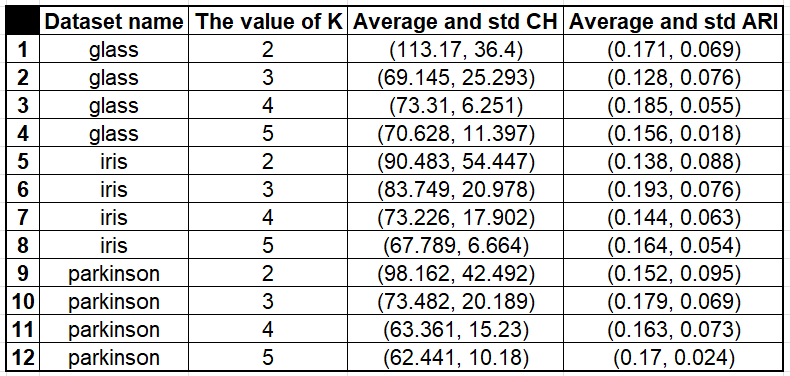